In [1]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2

print("TensorFlow version: ",tf.__version__)

2025-02-03 18:52:37.036452: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-03 18:52:37.036493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-03 18:52:37.037684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 18:52:37.043856: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version:  2.15.0


In [2]:
!wget -q https://adversarial-ml-tutorial.org/introduction/pig.jpg
!wget -q https://raw.githubusercontent.com/USCDataScience/dl4j-kerasimport-examples/master/dl4j-import-example/data/imagenet_class_index.json

In [3]:
EPS = 2./255
IMAGENET_LABELS = "imagenet_class_index.json"

with open(IMAGENET_LABELS) as f:
    IMAGENET_CLASSES = {int(i):x[1] for i,x in json.load(f).items()}

In [4]:
# Function to load up an image from a local filepath and
# display it
def show_image(image_path):
    image_pixels = plt.imread(image_path)
    plt.imshow(image_pixels)
    plt.show()
    return image_pixels

# Function to preprocess an image for performing inference
def preprocess_image(image_pixels, preprocess=False):
    if preprocess:
        image_pixels = preprocess_input(image_pixels)
    image_pixels = cv2.resize(image_pixels, (224, 224))
    image_pixels = np.expand_dims(image_pixels, axis=0)

    return image_pixels

# Clipping utility to project delta back to our favorable pixel
# range ([0 ,1])
def clip_eps(delta_tensor):
    return tf.clip_by_value(delta_tensor, 
                            clip_value_min=-EPS, 
                            clip_value_max=EPS)

# Parse the label
def get_label(preds):
    print(IMAGENET_CLASSES[preds.argmax()])

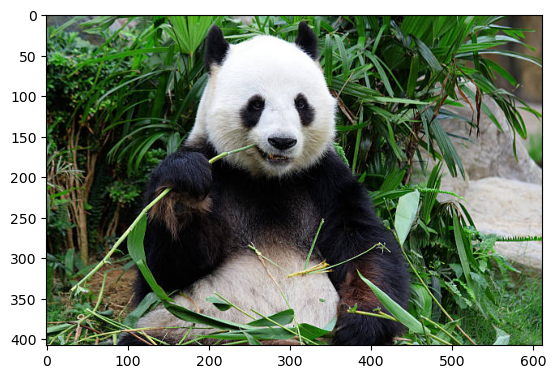

2025-02-03 18:54:51.074991: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-03 18:54:51.085220: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-03 18:54:51.087633: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
sample_image = show_image("./data/imagenet/giant_panda/giantpanda.jpg")
preprocessed_image = preprocess_image(sample_image, preprocess=True)
resnet50 = tf.keras.applications.ResNet50(weights="imagenet")

In [6]:
preds = resnet50.predict(preprocessed_image)
print("Predicted:", decode_predictions(preds, top=3)[0])
print("Class idx:", preds.argmax())

2025-02-03 18:54:53.548480: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


1/1 [==============================] - 2s 2s/step
Predicted: [('n02510455', 'giant_panda', 0.9987192), ('n02509815', 'lesser_panda', 0.0005748092), ('n02488702', 'colobus', 0.00029334117)]
Class idx: 388


In [13]:
def generate_adversaries_targeted(image_tensor, delta, model,
    true_index, target_indices, optimizer):
    # Loss function
    scc_loss = tf.keras.losses.SparseCategoricalCrossentropy()
    
    for t in range(350):
        plt.show()
        with tf.GradientTape() as tape:
            tape.watch(delta)
            inp = preprocess_input(image_tensor + delta)
            predictions = model(inp, training=False)
            true_loss = scc_loss(tf.convert_to_tensor([true_index]), predictions)
            target_losses = 0
            for i in target_indices:
                
                target_losses += scc_loss(tf.convert_to_tensor([i]), predictions)

            
            loss = true_loss + target_losses
            if t % 20 == 0:
                print(t, loss.numpy())
        # Get the gradients
        gradients = tape.gradient(loss, delta)
        
        # Update the weights
        optimizer.apply_gradients([(gradients, delta)])

        # Project the delta back (l-infinite norm)
        delta.assign_add(clip_eps(delta))

    return delta

def perturb_image(image_path, true, target, model, optimizer):
    # Load and preprocess image but a but without any `preprocess_input`
    sample_image = show_image(image_path)
    preprocessed_image = preprocess_image(sample_image)

    # Generate predictions before any adversaries
    unsafe_preds = model.predict(preprocess_input(preprocessed_image))
    print("Prediction before adv.:", decode_predictions(unsafe_preds, top=3)[0])

    # Initialize the perturbation quantity
    image_tensor = tf.constant(preprocessed_image, dtype=tf.float32)
    delta = tf.Variable(tf.zeros_like(image_tensor), trainable=True)

    # Get the learned delta and display it
    delta_tensor = generate_adversaries_targeted(image_tensor, delta, model, 
                                                 true, target, optimizer)
    plt.imshow(50*delta_tensor.numpy().squeeze()+0.5)
    plt.show()

    # See if the image changes
    plt.imshow((image_tensor + delta_tensor).numpy().squeeze()/255)
    plt.show()

    # Generate prediction
    perturbed_image = preprocess_input(image_tensor + delta_tensor)
    preds = model.predict(perturbed_image)
    print("Prediction after adv.:", decode_predictions(preds, top=10)[0])

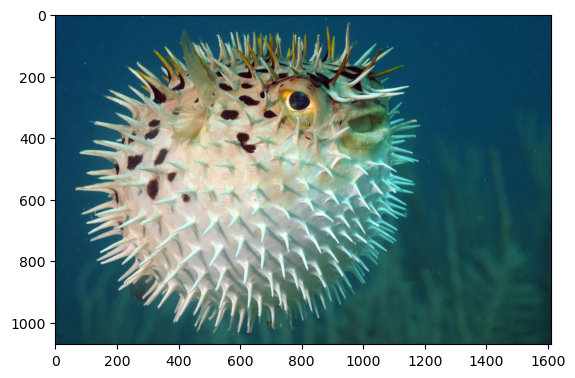

1/1 [==============================] - 0s 29ms/step
Prediction before adv.: [('n02655020', 'puffer', 0.99995553), ('n02319095', 'sea_urchin', 3.8992464e-05), ('n01914609', 'sea_anemone', 1.3283271e-06)]
0 122.13219
20 88.47411
40 68.773094
60 56.50843
80 48.97036
100 44.289673
120 41.42095
140 39.52401
160 38.064964
180 37.03372
200 36.250763
220 35.60298
240 35.036938
260 34.542816
280 34.101967
300 33.666573
320 33.29264
340 32.958294


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


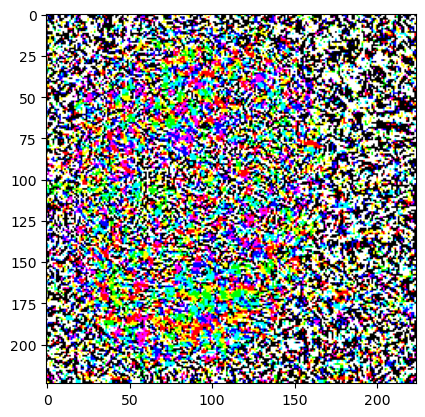

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


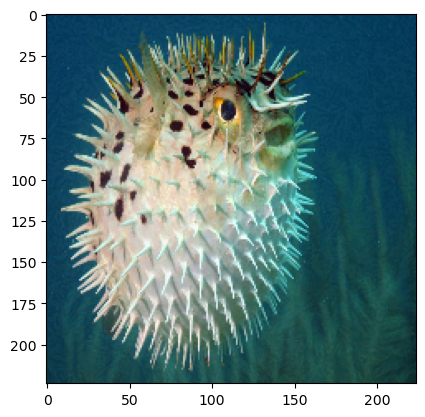

1/1 [==============================] - 0s 29ms/step
Prediction after adv.: [('n02655020', 'puffer', 0.092377454), ('n02319095', 'sea_urchin', 0.045313157), ('n02106550', 'Rottweiler', 0.039640028), ('n04039381', 'racket', 0.036962345), ('n10565667', 'scuba_diver', 0.02935591), ('n02643566', 'lionfish', 0.023024946), ('n09256479', 'coral_reef', 0.021334508), ('n01914609', 'sea_anemone', 0.02126459), ('n04370456', 'sweatshirt', 0.019857218), ('n03595614', 'jersey', 0.01339158)]


In [17]:
#@title Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
# perturb_image("./data/imagenet/giant_panda/giantpanda.jpg", 388, [389,508], resnet50, optimizer)
perturb_image("pufferfish.jpg", 397, [389,508,234,768,456], resnet50, optimizer)